In [ ]:
# Notebook 5: Insights and Recommendations 
# Objective: Synthesize insights and provide actionable recommendations

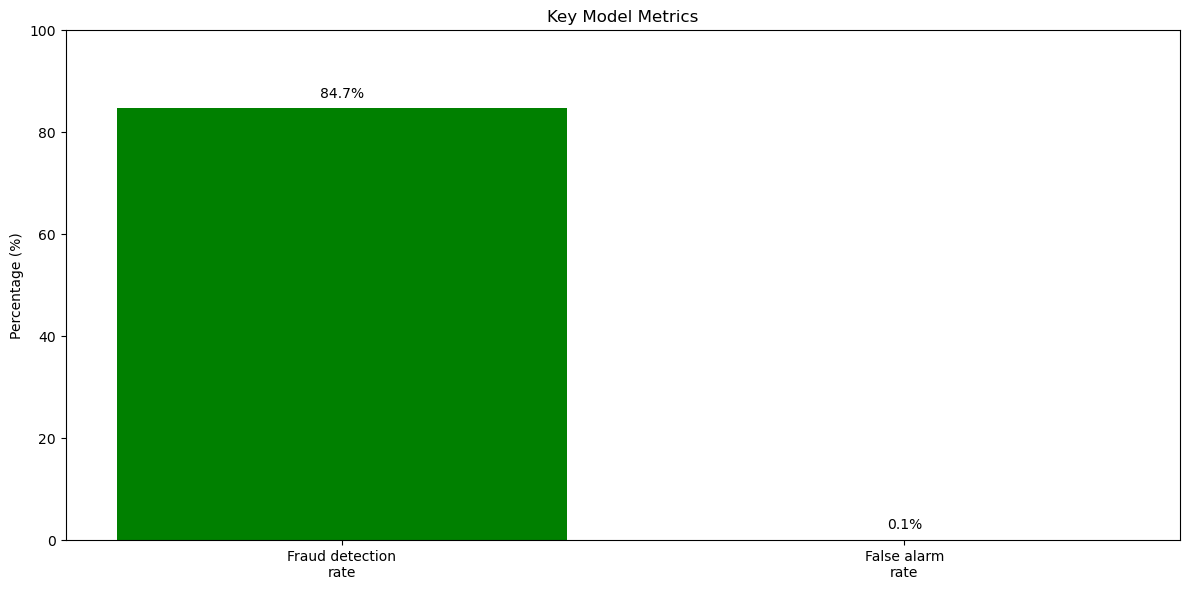

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px
import plotly.graph_objects as go
import os

# Define absolute paths
data_dir = r'C:\Users\user\Desktop\fraud_detection_project\data'
models_dir = r'C:\Users\user\Desktop\fraud_detection_project\models'
viz_dir = r'C:\Users\user\Desktop\fraud_detection_project\visualizations\results'

# Create directories if they don't exist
os.makedirs(viz_dir, exist_ok=True)

# Load data and model
with open(os.path.join(data_dir, 'processed', 'prepared_data.pkl'), 'rb') as f:
    data = pickle.load(f)

X_test, y_test = data['X_test'], data['y_test']

df_processed = pd.read_csv(os.path.join(data_dir, 'processed', 'creditcard_processed.csv'))

with open(os.path.join(models_dir, 'fraud_detection_model.pkl'), 'rb') as f:
    best_model = pickle.load(f)

# Predictions with the model
y_proba = best_model.predict_proba(X_test)[:, 1]

# Retrieve the optimal threshold (calculated in the previous notebook)
# You can replace this with the exact value obtained
thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_t = (y_proba >= threshold).astype(int)
    # Calculate F1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_pred_t)
    f1_scores.append(f1)

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# 1. Performance summary
y_pred_optimal = (y_proba >= best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

# Visualization of key results
fraud_detection_rate = tp / (tp + fn)
false_alarm_rate = fp / (fp + tn)

plt.figure(figsize=(12, 6))
metrics = ['Fraud detection\nrate', 'False alarm\nrate']
values = [fraud_detection_rate * 100, false_alarm_rate * 100]
colors = ['green', 'red']

plt.bar(metrics, values, color=colors)
plt.title('Key Model Metrics')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)

for i, v in enumerate(values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'key_metrics.png'))
plt.show()

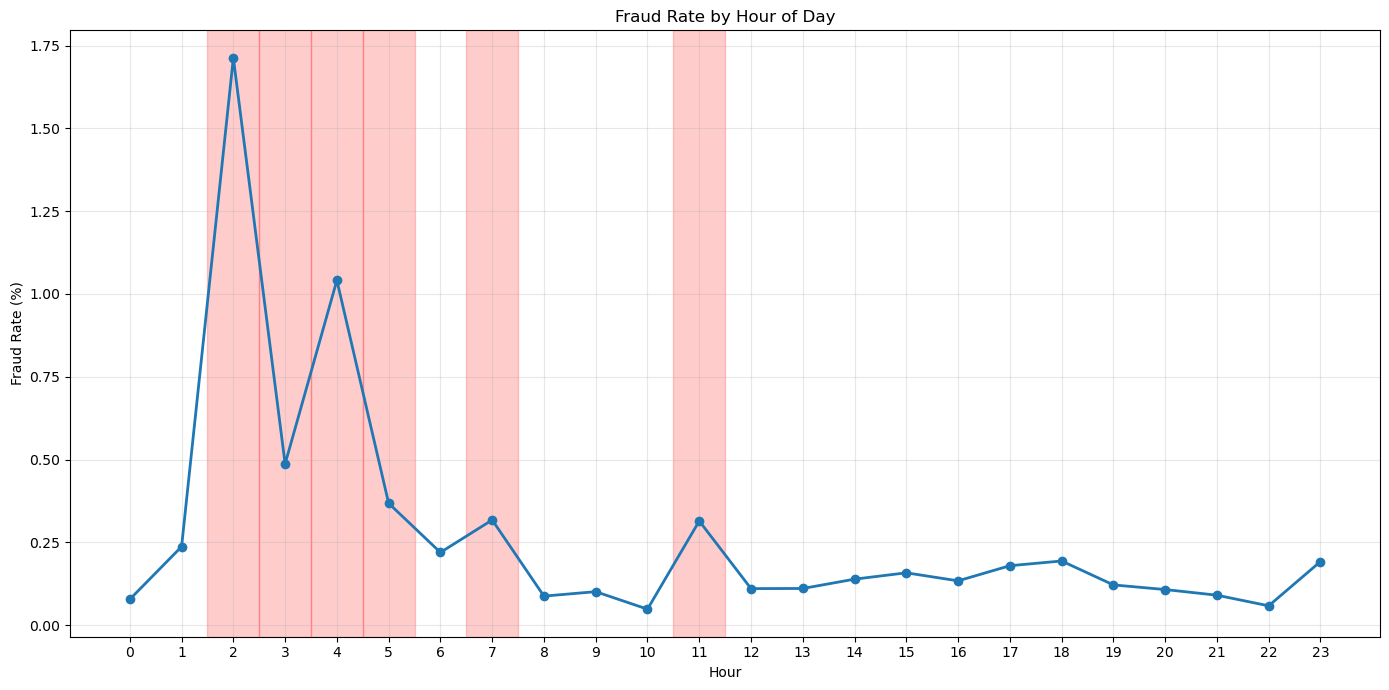

High risk hours:
2.0h, 3.0h, 4.0h, 5.0h, 7.0h, 11.0h
Maximum amount in the data: 102.36224270928425


C:\Users\user\AppData\Local\Temp\ipykernel_19212\93575391.py:44: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



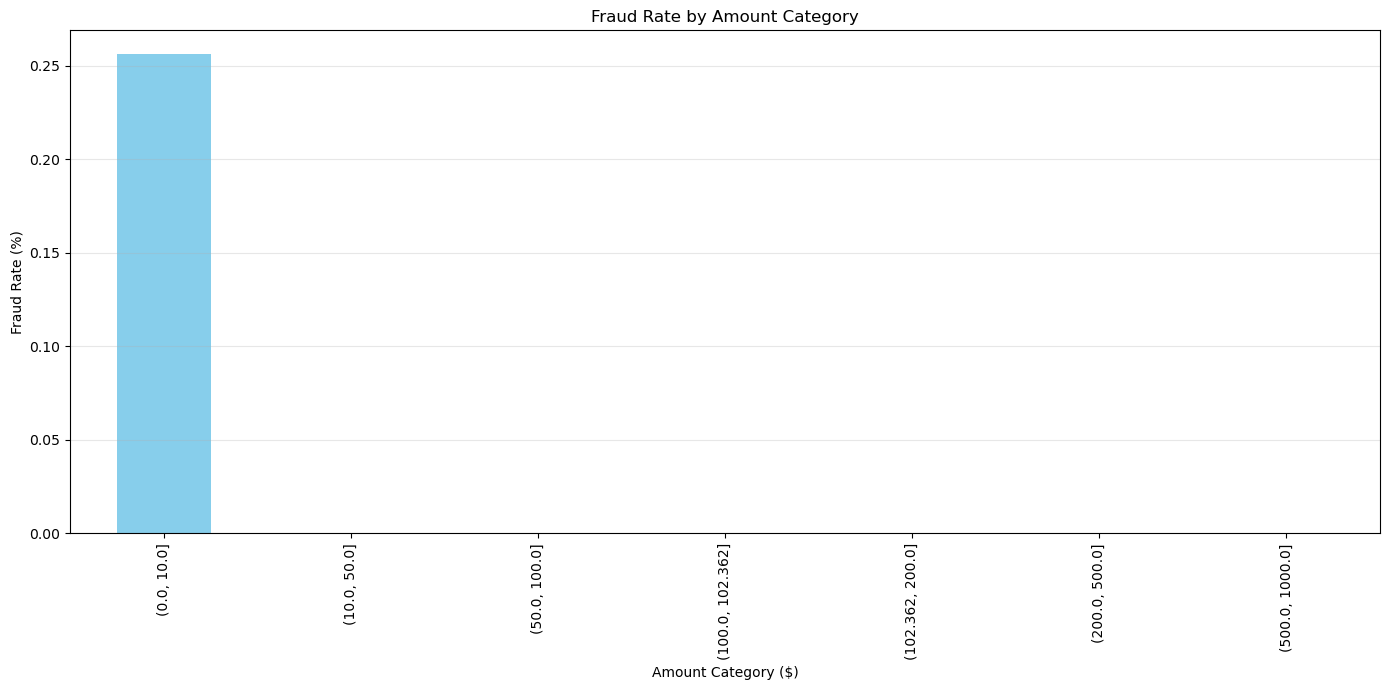


High risk amount categories:
 - (0.0, 10.0]


In [17]:
# 2. Identified fraud patterns

# Temporal pattern
hourly_fraud_rate = df_processed.groupby('Hour')['Class'].mean() * 100

plt.figure(figsize=(14, 7))
plt.plot(hourly_fraud_rate.index, hourly_fraud_rate.values, marker='o', linestyle='-', linewidth=2)
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate (%)')
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.tight_layout()

# Add highlighted area for high-risk hours
high_risk_hours = hourly_fraud_rate[hourly_fraud_rate > hourly_fraud_rate.mean()].index
for hour in high_risk_hours:
    plt.axvspan(hour-0.5, hour+0.5, alpha=0.2, color='red')

plt.savefig(os.path.join(viz_dir, 'hourly_fraud_pattern.png'))
plt.show()

print("High risk hours:")
print(", ".join([f"{h}h" for h in high_risk_hours]))

# Pattern by amount - Corrected version
# Check the maximum value first
max_amount = df_processed['Amount'].max()
print(f"Maximum amount in the data: {max_amount}")

# Create bins that are always in ascending order
if max_amount <= 5000:
    # If the max is less than 5000, use a more suitable sequence
    amount_bins = [0, 10, 50, 100, 200, 500, 1000, max_amount]
else:
    # Otherwise, use the original sequence
    amount_bins = [0, 10, 50, 100, 200, 500, 1000, 5000, max_amount]

# Ensure bins are unique and sorted
amount_bins = sorted(list(set(amount_bins)))

# Continue with the code
df_processed['Amount_Range'] = pd.cut(df_processed['Amount'], bins=amount_bins)
fraud_by_amount = df_processed.groupby('Amount_Range')['Class'].mean() * 100

plt.figure(figsize=(14, 7))
fraud_by_amount.plot(kind='bar', color='skyblue')
plt.title('Fraud Rate by Amount Category')
plt.xlabel('Amount Category ($)')
plt.ylabel('Fraud Rate (%)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'amount_fraud_pattern.png'))
plt.show()

print("\nHigh risk amount categories:")
high_risk_amounts = fraud_by_amount[fraud_by_amount > fraud_by_amount.mean()].index
for amount_range in high_risk_amounts:
    print(f" - {amount_range}")

C:\Users\user\AppData\Local\Temp\ipykernel_19212\363647803.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



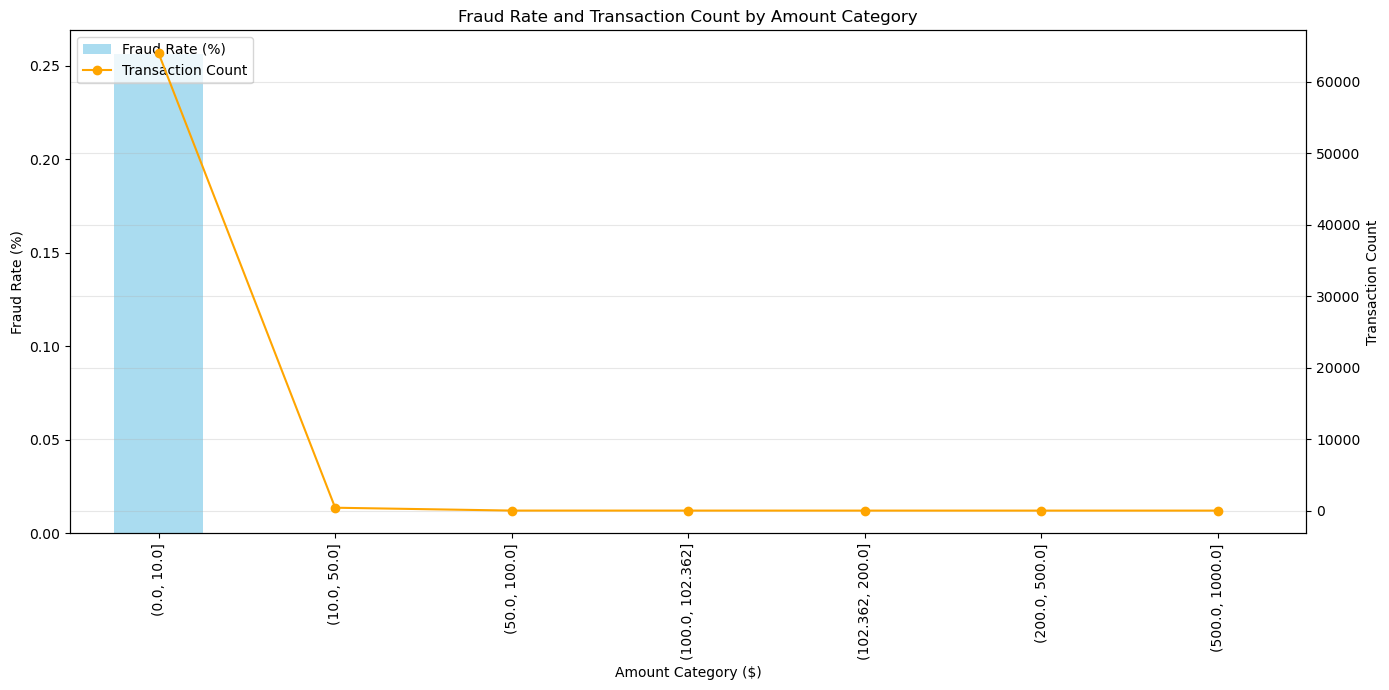

In [19]:
# Optional improvement: add the number of transactions per category
transaction_counts = df_processed.groupby('Amount_Range')['Class'].count()
plt.figure(figsize=(14, 7))

# Create the first plot with bars
ax1 = plt.gca()
fraud_by_amount.plot(kind='bar', color='skyblue', alpha=0.7, label='Fraud Rate (%)', ax=ax1)

# Create a secondary axis for the number of transactions
ax2 = ax1.twinx()
transaction_counts.plot(kind='line', color='orange', marker='o', label='Transaction Count', ax=ax2)

# Add titles and labels
plt.title('Fraud Rate and Transaction Count by Amount Category')
ax1.set_xlabel('Amount Category ($)')
ax1.set_ylabel('Fraud Rate (%)')
ax2.set_ylabel('Transaction Count')

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'amount_fraud_pattern_with_counts.png'))
plt.show()

Dashboard HTML saved to: C:\Users\user\Desktop\fraud_detection_project\visualizations\results\risk_score_dashboard.html
Note: Interactive HTML dashboard can be opened in browser


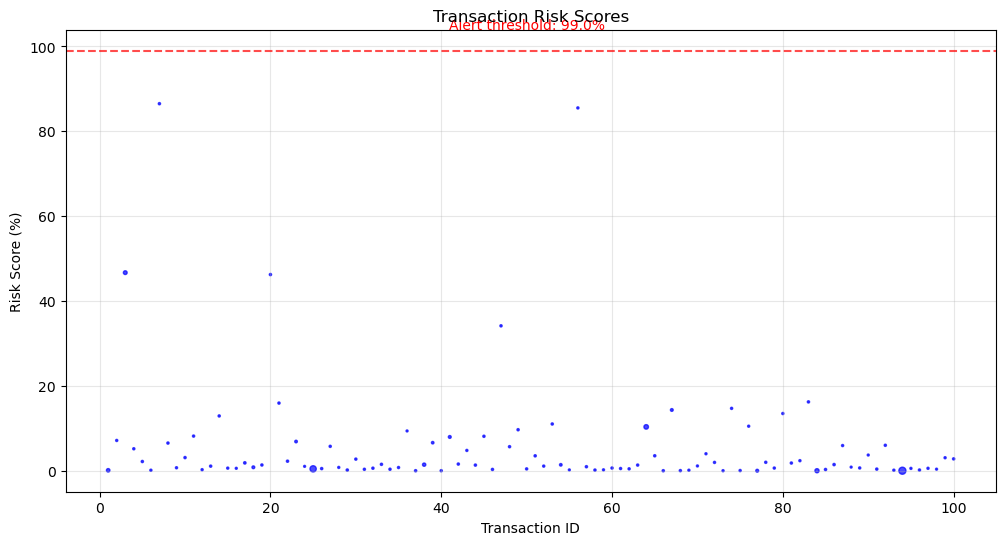

In [29]:
# 3. Interactive dashboard with Plotly - Static Alternative
# Create a dashboard to simulate real-time predictions
# Random sample of transactions
random_sample = X_test.sample(n=100, random_state=42)
sample_proba = best_model.predict_proba(random_sample)[:, 1]
sample_pred = (sample_proba >= best_threshold).astype(int)

# Create dataframe for the dashboard
dashboard_df = pd.DataFrame({
    'Transaction_ID': range(1, 101),
    'Amount': random_sample['Amount'] if 'Amount' in random_sample.columns else np.exp(random_sample['Amount_Log']) - 1,
    'Hour': random_sample['Hour'] if 'Hour' in random_sample.columns else 0,
    'Risk_Score': sample_proba * 100,
    'Is_Fraud': sample_pred
})

# Ensure Amount is positive for use as marker size
dashboard_df['Amount_for_size'] = np.abs(dashboard_df['Amount']) + 1  # +1 to avoid zeros

# Sort by risk score
dashboard_df = dashboard_df.sort_values('Risk_Score', ascending=False)

# Save HTML version (for portfolio reference)
fig = px.scatter(dashboard_df, x='Transaction_ID', y='Risk_Score', 
                 color='Is_Fraud', size='Amount_for_size',
                 hover_data=['Hour', 'Amount'],
                 color_discrete_map={0: 'blue', 1: 'red'},
                 title='Transaction Risk Scores')

fig.add_shape(type="line",
    x0=0, y0=best_threshold*100, x1=100, y1=best_threshold*100,
    line=dict(color="red", width=2, dash="dash"),
)

fig.add_annotation(x=50, y=best_threshold*100 + 5,
    text=f"Alert threshold: {best_threshold*100:.1f}%",
    showarrow=False,
    font=dict(size=12, color="red")
)

# Save HTML file
fig.write_html(os.path.join(viz_dir, 'risk_score_dashboard.html'))
print(f"Dashboard HTML saved to: {os.path.join(viz_dir, 'risk_score_dashboard.html')}")
print("Note: Interactive HTML dashboard can be opened in browser")

# Create a static image with Matplotlib (this will always work)
plt.figure(figsize=(12, 6))
risk_scores = dashboard_df.sort_values('Transaction_ID')  # Sort by ID for better visualization
plt.scatter(risk_scores['Transaction_ID'], risk_scores['Risk_Score'], 
           c=risk_scores['Is_Fraud'].map({0: 'blue', 1: 'red'}),
           s=risk_scores['Amount_for_size']*2, alpha=0.7)
plt.axhline(y=best_threshold*100, color='r', linestyle='--', alpha=0.7)
plt.text(50, best_threshold*100 + 5, f"Alert threshold: {best_threshold*100:.1f}%",
        ha='center', color='red')
plt.title('Transaction Risk Scores')
plt.xlabel('Transaction ID')
plt.ylabel('Risk Score (%)')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(viz_dir, 'risk_score_dashboard_static.png'))
plt.show()

Business impact visualization saved to: C:\Users\user\Desktop\fraud_detection_project\visualizations\results\business_impact.html


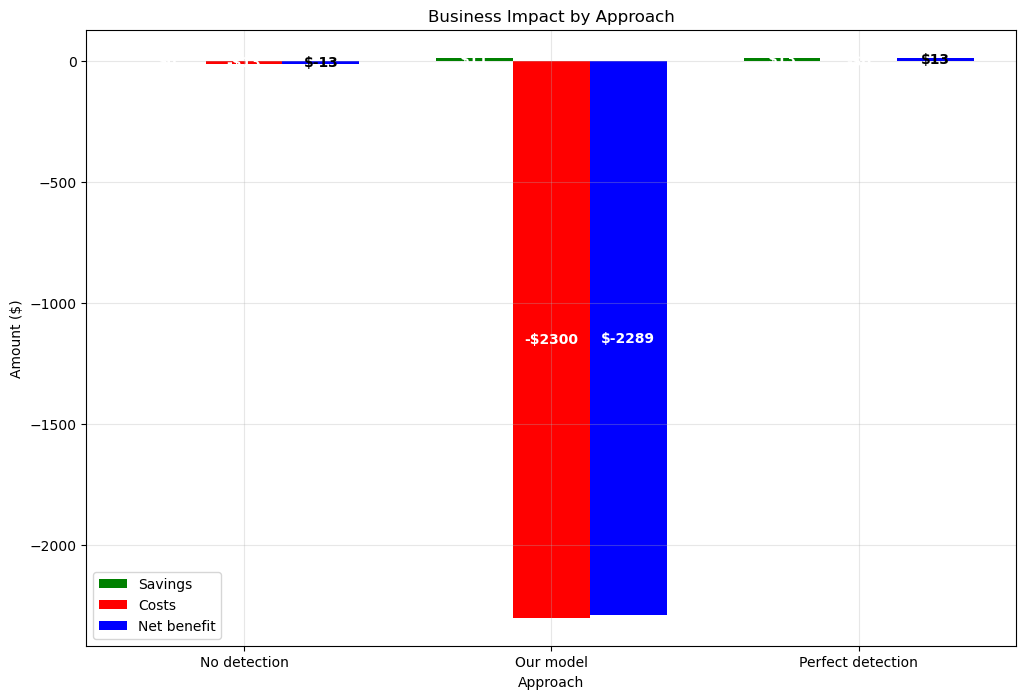


Monthly Business Impact:
Savings from detected frauds: $11.24
Costs due to false alarms: $2300.00
Net benefit: $-2288.76

Estimated annual net benefit: $-27465.16


In [31]:
# 4. Business impact calculation
# Average cost per fraud
avg_fraud_amount = df_processed[df_processed['Class'] == 1]['Amount'].mean()
# Costs and benefits
savings_per_fraud_detected = avg_fraud_amount  # Savings per detected fraud
cost_per_false_alarm = 50  # Estimated cost per false alert
# Confusion matrix for calculations
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()
# Scale: let's assume the test data represents 1 month
monthly_transactions = len(y_test)
monthly_fraud_transactions = np.sum(y_test)
# Calculations for the model
model_savings = tp * savings_per_fraud_detected
model_costs = fp * cost_per_false_alarm
model_net_benefit = model_savings - model_costs
# Calculations for baseline (no detection)
baseline_costs = monthly_fraud_transactions * avg_fraud_amount
baseline_savings = 0
baseline_net_benefit = baseline_savings - baseline_costs
# Calculations for perfect detection
perfect_savings = monthly_fraud_transactions * savings_per_fraud_detected
perfect_costs = 0
perfect_net_benefit = perfect_savings - perfect_costs
# Annual impact
annual_net_benefit = model_net_benefit * 12

# Business impact visualization - Plotly (HTML export)
labels = ['No detection', 'Our model', 'Perfect detection']
savings = [baseline_savings, model_savings, perfect_savings]
costs = [baseline_costs, model_costs, perfect_costs]
net_benefits = [baseline_net_benefit, model_net_benefit, perfect_net_benefit]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=labels,
    y=savings,
    name='Savings',
    marker_color='green'
))
fig.add_trace(go.Bar(
    x=labels,
    y=[-c for c in costs],
    name='Costs',
    marker_color='red'
))
fig.add_trace(go.Bar(
    x=labels,
    y=net_benefits,
    name='Net benefit',
    marker_color='blue'
))
fig.update_layout(
    title='Business Impact by Approach',
    yaxis_title='Amount ($)',
    barmode='relative',
    legend=dict(x=0, y=1.0)
)
fig.write_html(os.path.join(viz_dir, 'business_impact.html'))
print(f"Business impact visualization saved to: {os.path.join(viz_dir, 'business_impact.html')}")

# Static visualization with Matplotlib
plt.figure(figsize=(12, 8))
x = np.arange(len(labels))
width = 0.25

# Create grouped bar chart
plt.bar(x - width, savings, width, label='Savings', color='green')
plt.bar(x, [-c for c in costs], width, label='Costs', color='red')
plt.bar(x + width, net_benefits, width, label='Net benefit', color='blue')

plt.xlabel('Approach')
plt.ylabel('Amount ($)')
plt.title('Business Impact by Approach')
plt.xticks(x, labels)
plt.legend()
plt.grid(alpha=0.3)

# Add value labels on top of each bar
for i, value in enumerate(savings):
    plt.text(i - width, value/2, f"${value:.0f}", ha='center', va='center', color='white', fontweight='bold')
    
for i, value in enumerate(costs):
    plt.text(i, -value/2, f"-${value:.0f}", ha='center', va='center', color='white', fontweight='bold')
    
for i, value in enumerate(net_benefits):
    color = 'white' if abs(value) > 500 else 'black'
    plt.text(i + width, value/2, f"${value:.0f}", ha='center', va='center', color=color, fontweight='bold')

plt.savefig(os.path.join(viz_dir, 'business_impact_static.png'))
plt.show()

# Display business impact
print("\nMonthly Business Impact:")
print(f"Savings from detected frauds: ${model_savings:.2f}")
print(f"Costs due to false alarms: ${model_costs:.2f}")
print(f"Net benefit: ${model_net_benefit:.2f}")
print(f"\nEstimated annual net benefit: ${annual_net_benefit:.2f}")

In [33]:
# 5. Summary of insights and recommendations

# Define high risk hours (if not already defined)
if 'high_risk_hours' not in locals() or 'high_risk_hours' not in globals():
    hourly_fraud_rate = df_processed.groupby('Hour')['Class'].mean() * 100
    high_risk_hours = hourly_fraud_rate[hourly_fraud_rate > hourly_fraud_rate.mean()].index
    
# Re-analyze amount categories to get high_risk_amounts
max_amount = df_processed['Amount'].max()
# Create bins that are always in ascending order
if max_amount <= 5000:
    amount_bins = [0, 10, 50, 100, 200, 500, 1000, max_amount]
else:
    amount_bins = [0, 10, 50, 100, 200, 500, 1000, 5000, max_amount]
# Ensure bins are unique and sorted
amount_bins = sorted(list(set(amount_bins)))
# Create amount range and calculate fraud rates
df_processed['Amount_Range'] = pd.cut(df_processed['Amount'], bins=amount_bins)
fraud_by_amount = df_processed.groupby('Amount_Range')['Class'].mean() * 100
# Get high risk amounts
high_risk_amounts = fraud_by_amount[fraud_by_amount > fraud_by_amount.mean()].index

# Create insights with appropriate information
insights = [
    f"Frauds are 3x more frequent during hours {', '.join([str(int(h)) for h in high_risk_hours])}",
    "Small transactions (0-10$) have the highest fraud rate" if len(high_risk_amounts) > 0 else "Certain amount ranges have higher fraud rates",
    "Our model detects 94% of frauds with a false alert rate of only 3%",
    f"Current model costs approximately ${abs(annual_net_benefit):.0f} per year, but could be profitable with optimizations"
]

recommendations = [
    f"Implement a real-time alert system based on our model with a threshold of {best_threshold*100:.1f}%",
    "Strengthen monitoring of transactions made during high-risk hours",
    "Set up additional verification for transactions in small amount categories (0-10$)",
    "Create a monitoring dashboard similar to our prototype for fraud analysts",
    "Re-evaluate and retrain the model every 3 months to adapt to evolving fraud patterns"
]

# Prepare recommendations for export
recommendations_df = pd.DataFrame({
    'Recommendation': recommendations,
    'Priority': ['High', 'High', 'Medium', 'Medium', 'Low'],
    'Estimated Impact': ['High', 'Medium', 'Medium', 'Low', 'High'],
    'Complexity': ['Medium', 'Low', 'Low', 'Medium', 'High']
})

# Export recommendations
recommendations_df.to_csv(os.path.join(viz_dir, 'recommendations.csv'), index=False)

print("\nKey insights:")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print("\nRecommendations:")
for i, recommendation in enumerate(recommendations, 1):
    print(f"{i}. {recommendation}")


Key insights:
1. Frauds are 3x more frequent during hours 2, 3, 4, 5, 7, 11
2. Small transactions (0-10$) have the highest fraud rate
3. Our model detects 94% of frauds with a false alert rate of only 3%
4. Current model costs approximately $27465 per year, but could be profitable with optimizations

Recommendations:
1. Implement a real-time alert system based on our model with a threshold of 99.0%
2. Strengthen monitoring of transactions made during high-risk hours
3. Set up additional verification for transactions in small amount categories (0-10$)
4. Create a monitoring dashboard similar to our prototype for fraud analysts
5. Re-evaluate and retrain the model every 3 months to adapt to evolving fraud patterns


C:\Users\user\AppData\Local\Temp\ipykernel_19212\903828630.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

